In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
from matplotlib.dates import YearLocator, DateFormatter
import matplotlib.dates as mdates
from matplotlib.dates import date2num
from dateutil.relativedelta import relativedelta
import altair as alt

In [45]:
# Import the test data set for the current strategy
# Import ticker data for 
price_hist = pd.read_csv('test_60_40_advanced.csv')
predictions = pd.read_csv('Predictions.csv')
start_date = '2019-12-01' # This date is typically 1 month before the start date (see below). This givces rolling data into the trade window
strategy_start = '2020-01-01'
tspan = 3 # 3 years 
test = datetime.strptime(start_date, '%Y-%m-%d')+relativedelta(years=1) # this is useful 

# Default Benchmark Strategy
Equity = 0.6
Debt = 0.4

# Trade Strategy based on model predictions
Equity_adj = 0.80 # was 70

# Risk Free Treasury Rates - For use in Sharpe, Average
#rf_rate = np.mean([.0155,.0009, .0008,0.045])*100 # averaging from Jan 2020 to Dec 31, 2023 in this scenario
rf_rate = .02

In [46]:
def trade_timespan(start_date,tspan):
    trade_years = []
    for i in range(0,tspan+1):
        temp =  datetime.strptime(start_date, '%Y-%m-%d')+relativedelta(years=i)
        temp = temp +relativedelta(months=1)
        yr = str(temp.date())
        trade_years.append(yr)
    return trade_years

In [47]:
trade_years = trade_timespan(start_date,tspan)
trade_years

['2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01']

In [48]:
price_hist

,Date,SPY_Adj Close,SPY_EMA,SPY_RSI,SPY_MACD,SPY_Signal,SPY_MACD_minus_signal,XLE_Adj Close,XLU_Adj Close,XLK_Adj Close,...,XLRE_Adj Close,TLT_Adj Close,TLT_EMA,TLT_RSI,TLT_MACD,TLT_Signal,TLT_MACD_minus_signal,HYBL_Adj Close,SJNK_Adj Close,SPTI_Adj Close
0,2007-11-01,111.071999,NaN,NaN,NaN,NaN,NaN,46.070751,23.679356,22.312790,...,NaN,58.544654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.764126
1,2007-11-02,111.197037,NaN,NaN,NaN,NaN,NaN,46.937107,23.872980,22.360449,...,NaN,58.336575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.663439
2,2007-11-05,110.351311,NaN,NaN,NaN,NaN,NaN,46.559624,24.134943,22.328674,...,NaN,58.310921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.659626
3,2007-11-06,111.836884,NaN,NaN,NaN,NaN,NaN,48.112831,24.157721,22.447817,...,NaN,58.028999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.625263
4,2007-11-07,108.777466,110.646939,NaN,NaN,NaN,NaN,46.132645,23.605335,21.844131,...,NaN,58.131500,58.191730,NaN,NaN,NaN,NaN,NaN,NaN,20.648180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3946,2023-07-10,439.660004,439.884655,60.943045,4.807296,5.332990,-0.525695,81.419998,65.110001,171.660004,...,37.919998,99.209999,100.067279,37.603417,-0.586157,-0.204532,-0.381625,27.565001,24.480000,28.049999
3947,2023-07-11,442.459991,440.743100,64.394079,4.767644,5.219921,-0.452277,83.209999,65.919998,172.029999,...,38.349998,99.720001,99.951520,40.636522,-0.650608,-0.293747,-0.356861,27.639999,24.559999,28.059999
3948,2023-07-12,446.019989,442.502063,68.236914,4.966234,5.169184,-0.202950,83.980003,66.879997,173.979996,...,38.529999,100.830002,100.244347,46.708378,-0.605142,-0.356026,-0.249116,27.754000,24.709999,28.270000
3949,2023-07-13,449.559998,444.854708,71.527644,5.347623,5.204871,0.142751,83.660004,67.110001,176.250000,...,38.790001,101.889999,100.792898,51.780515,-0.478066,-0.380434,-0.097632,27.844999,24.830000,28.480000


In [49]:
predictions


#predictions = predictions.tail(-1)
#predictions.drop(index=predictions.index[0], axis=0, inplace=True)
#predictions

,Date,Bull_Bear,Prediction,Base_Prediction
0,2019-10-30,1.0,1,1
1,2019-12-11,0.0,0,0
2,2020-01-29,0.0,0,0
3,2020-03-15,0.0,1,1
4,2020-04-29,1.0,1,1
5,2020-06-10,0.0,0,0
6,2020-07-29,1.0,1,0
7,2020-09-16,0.0,0,0
8,2020-11-05,1.0,1,1
9,2020-12-16,0.0,0,0


In [51]:
price_hist = price_hist[['Date','SPY_Adj Close','TLT_Adj Close']]
price_hist

,Date,SPY_Adj Close,TLT_Adj Close
0,2007-11-01,111.071999,58.544654
1,2007-11-02,111.197037,58.336575
2,2007-11-05,110.351311,58.310921
3,2007-11-06,111.836884,58.028999
4,2007-11-07,108.777466,58.131500
...,...,...,...
3946,2023-07-10,439.660004,99.209999
3947,2023-07-11,442.459991,99.720001
3948,2023-07-12,446.019989,100.830002
3949,2023-07-13,449.559998,101.889999


In [52]:
def portfolio_weights(predictions,Equity_adj):
    predictions =predictions.copy()
    predictions['Equity'] = Equity_adj
    predictions.loc[predictions['Prediction'] == 0, 'Equity'] = 0.40
    predictions['Debt'] = 1-predictions['Equity']


    return predictions

In [53]:
df = portfolio_weights(predictions,Equity_adj)
df

,Date,Bull_Bear,Prediction,Base_Prediction,Equity,Debt
0,2019-10-30,1.0,1,1,0.8,0.2
1,2019-12-11,0.0,0,0,0.4,0.6
2,2020-01-29,0.0,0,0,0.4,0.6
3,2020-03-15,0.0,1,1,0.8,0.2
4,2020-04-29,1.0,1,1,0.8,0.2
5,2020-06-10,0.0,0,0,0.4,0.6
6,2020-07-29,1.0,1,0,0.8,0.2
7,2020-09-16,0.0,0,0,0.4,0.6
8,2020-11-05,1.0,1,1,0.8,0.2
9,2020-12-16,0.0,0,0,0.4,0.6


In [54]:
# this takes in price data (data), trade strategy(df), start date (typically one month prior to any trade strategy)

def backtest_func(data,df,start_date,strategy_start):
    backtest = (data[data['Date']>=start_date]).copy()
    backtest = pd.merge(backtest,df, how='left', on = 'Date', suffixes = ('_left', '_right'))
    # add in fed dates
    backtest.fillna(method='ffill', inplace=True)
    backtest = backtest[backtest['Date']>=strategy_start]

    return backtest

In [55]:
backtest = backtest_func(price_hist,df,start_date,strategy_start)
backtest.head(100)

,Date,SPY_Adj Close,TLT_Adj Close,Bull_Bear,Prediction,Base_Prediction,Equity,Debt
21,2020-01-02,307.375671,127.906021,0.0,0.0,0.0,0.4,0.6
22,2020-01-03,305.048157,129.875839,0.0,0.0,0.0,0.4,0.6
23,2020-01-06,306.211945,129.138321,0.0,0.0,0.0,0.4,0.6
24,2020-01-07,305.350952,128.503525,0.0,0.0,0.0,0.4,0.6
25,2020-01-08,306.978302,127.653976,0.0,0.0,0.0,0.4,0.6
...,...,...,...,...,...,...,...,...
116,2020-05-19,277.871765,153.685547,1.0,1.0,1.0,0.8,0.2
117,2020-05-20,282.592255,154.145737,1.0,1.0,1.0,0.8,0.2
118,2020-05-21,280.641266,154.530685,1.0,1.0,1.0,0.8,0.2
119,2020-05-22,281.174225,155.460388,1.0,1.0,1.0,0.8,0.2


In [56]:

def stategy_calculator(backtest,strategy_start,Equity,Debt):
    backtest = backtest.copy()
    backtest['SPY_change'] = backtest['SPY_Adj Close'].pct_change()
    #backtest['SPY_agg'] = backtest['SPY_change'].cumsum()
    backtest['TLT_change'] = backtest['TLT_Adj Close'].pct_change()
    #backtest['TLT_agg'] = backtest['TLT_change'].cumsum()

    backtest = backtest[backtest['Date']>=strategy_start]
    backtest['SPY_weighted']=backtest['Equity']*backtest['SPY_change']
    backtest['SPY_standard']=Equity*backtest['SPY_change']
    backtest['TLT_weighted']=backtest['Debt']*backtest['TLT_change']
    backtest['TLT_standard']=Debt*backtest['TLT_change']
    backtest['Optimized_Return'] = backtest['SPY_weighted']+backtest['TLT_weighted']
    backtest['Standard_Return'] = backtest['SPY_standard']+backtest['TLT_standard']
    backtest['SPY_agg'] = backtest['SPY_change'].cumsum() # Just to show individual index performance 100% allocation
    backtest['TLT_agg'] = backtest['TLT_change'].cumsum() # Just to show individual index performance 100% allocation
    backtest['Optimized_agg'] =backtest['Optimized_Return'].cumsum()
    backtest['Standard_agg'] =backtest['Standard_Return'].cumsum()
    

    return backtest

In [57]:
backtest = stategy_calculator(backtest,strategy_start,Equity,Debt)


In [58]:
backtest

,Date,SPY_Adj Close,TLT_Adj Close,Bull_Bear,Prediction,Base_Prediction,Equity,Debt,SPY_change,TLT_change,SPY_weighted,SPY_standard,TLT_weighted,TLT_standard,Optimized_Return,Standard_Return,SPY_agg,TLT_agg,Optimized_agg,Standard_agg
21,2020-01-02,307.375671,127.906021,0.0,0.0,0.0,0.4,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,2020-01-03,305.048157,129.875839,0.0,0.0,0.0,0.4,0.6,-0.007572,0.015401,-0.003029,-0.004543,0.009240,0.006160,0.006211,0.001617,-0.007572,0.015401,0.006211,0.001617
23,2020-01-06,306.211945,129.138321,0.0,0.0,0.0,0.4,0.6,0.003815,-0.005679,0.001526,0.002289,-0.003407,-0.002271,-0.001881,0.000018,-0.003757,0.009722,0.004330,0.001634
24,2020-01-07,305.350952,128.503525,0.0,0.0,0.0,0.4,0.6,-0.002812,-0.004916,-0.001125,-0.001687,-0.002949,-0.001966,-0.004074,-0.003653,-0.006569,0.004806,0.000256,-0.002019
25,2020-01-08,306.978302,127.653976,0.0,0.0,0.0,0.4,0.6,0.005329,-0.006611,0.002132,0.003198,-0.003967,-0.002644,-0.001835,0.000553,-0.001239,-0.001805,-0.001579,-0.001466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,2023-07-10,439.660004,99.209999,0.0,0.0,0.0,0.4,0.6,0.002531,0.001312,0.001012,0.001519,0.000787,0.000525,0.001800,0.002043,0.457039,-0.192505,0.305739,0.197222
906,2023-07-11,442.459991,99.720001,0.0,0.0,0.0,0.4,0.6,0.006369,0.005141,0.002547,0.003821,0.003084,0.002056,0.005632,0.005877,0.463408,-0.187364,0.311371,0.203099
907,2023-07-12,446.019989,100.830002,0.0,0.0,0.0,0.4,0.6,0.008046,0.011131,0.003218,0.004828,0.006679,0.004452,0.009897,0.009280,0.471454,-0.176233,0.321268,0.212379
908,2023-07-13,449.559998,101.889999,0.0,0.0,0.0,0.4,0.6,0.007937,0.010513,0.003175,0.004762,0.006308,0.004205,0.009482,0.008967,0.479391,-0.165720,0.330751,0.221346


In [59]:
backtest['Meeting'] = backtest['Date'].isin(df['Date']).astype(int)
backtest.tail(100)

,Date,SPY_Adj Close,TLT_Adj Close,Bull_Bear,Prediction,Base_Prediction,Equity,Debt,SPY_change,TLT_change,...,SPY_standard,TLT_weighted,TLT_standard,Optimized_Return,Standard_Return,SPY_agg,TLT_agg,Optimized_agg,Standard_agg,Meeting
810,2023-02-21,396.101318,99.106033,0.0,0.0,0.0,0.4,0.6,-0.020061,-0.019437,...,-0.012037,-0.011662,-0.007775,-0.019687,-0.019812,0.349430,-0.198840,0.252157,0.130122,0
811,2023-02-22,395.555420,100.014267,0.0,0.0,0.0,0.4,0.6,-0.001378,0.009164,...,-0.000827,0.005499,0.003666,0.004947,0.002839,0.348051,-0.189675,0.257104,0.132961,0
812,2023-02-23,397.659546,100.991615,0.0,0.0,0.0,0.4,0.6,0.005319,0.009772,...,0.003192,0.005863,0.003909,0.007991,0.007100,0.353371,-0.179903,0.265095,0.140061,0
813,2023-02-24,393.411591,99.678619,0.0,0.0,0.0,0.4,0.6,-0.010682,-0.013001,...,-0.006409,-0.007801,-0.005200,-0.012074,-0.011610,0.342688,-0.192904,0.253022,0.128451,0
814,2023-02-27,394.751495,99.955040,0.0,0.0,0.0,0.4,0.6,0.003406,0.002773,...,0.002044,0.001664,0.001109,0.003026,0.003153,0.346094,-0.190131,0.256048,0.131604,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,2023-07-10,439.660004,99.209999,0.0,0.0,0.0,0.4,0.6,0.002531,0.001312,...,0.001519,0.000787,0.000525,0.001800,0.002043,0.457039,-0.192505,0.305739,0.197222,0
906,2023-07-11,442.459991,99.720001,0.0,0.0,0.0,0.4,0.6,0.006369,0.005141,...,0.003821,0.003084,0.002056,0.005632,0.005877,0.463408,-0.187364,0.311371,0.203099,0
907,2023-07-12,446.019989,100.830002,0.0,0.0,0.0,0.4,0.6,0.008046,0.011131,...,0.004828,0.006679,0.004452,0.009897,0.009280,0.471454,-0.176233,0.321268,0.212379,0
908,2023-07-13,449.559998,101.889999,0.0,0.0,0.0,0.4,0.6,0.007937,0.010513,...,0.004762,0.006308,0.004205,0.009482,0.008967,0.479391,-0.165720,0.330751,0.221346,0


In [15]:
# need to think about how to factor in dividends, I think the dividend column and adj close columsn can be added to get cummulative total

#backtest['SPY_change'] = backtest['SPY_Adj Close'].pct_change()
##backtest['SPY_agg'] = backtest['SPY_change'].cumsum()
#backtest['TLT_change'] = backtest['TLT_Adj Close'].pct_change()
##backtest['TLT_agg'] = backtest['TLT_change'].cumsum()

In [16]:
# Filter again to get full year backtest returns/clip prior data used for allocations before first fed meeting
#backtest = backtest[backtest['Date']>='2020-01-01']
#backtest['SPY_weighted']=backtest['Equity']*backtest['SPY_change']
#backtest['TLT_weighted']=backtest['Debt']*backtest['TLT_change']
#backtest['Optimized_Return'] = backtest['SPY_weighted']+backtest['TLT_weighted']
#backtest['SPY_agg'] = backtest['SPY_change'].cumsum()
#backtest['Optimized_agg'] =backtest['Optimized_Return'].cumsum()

In [60]:
# find predeeding dates for plotting aka what was our prediction the month prior


predict_error = predictions[(predictions['Prediction']!= predictions['Bull_Bear'])]


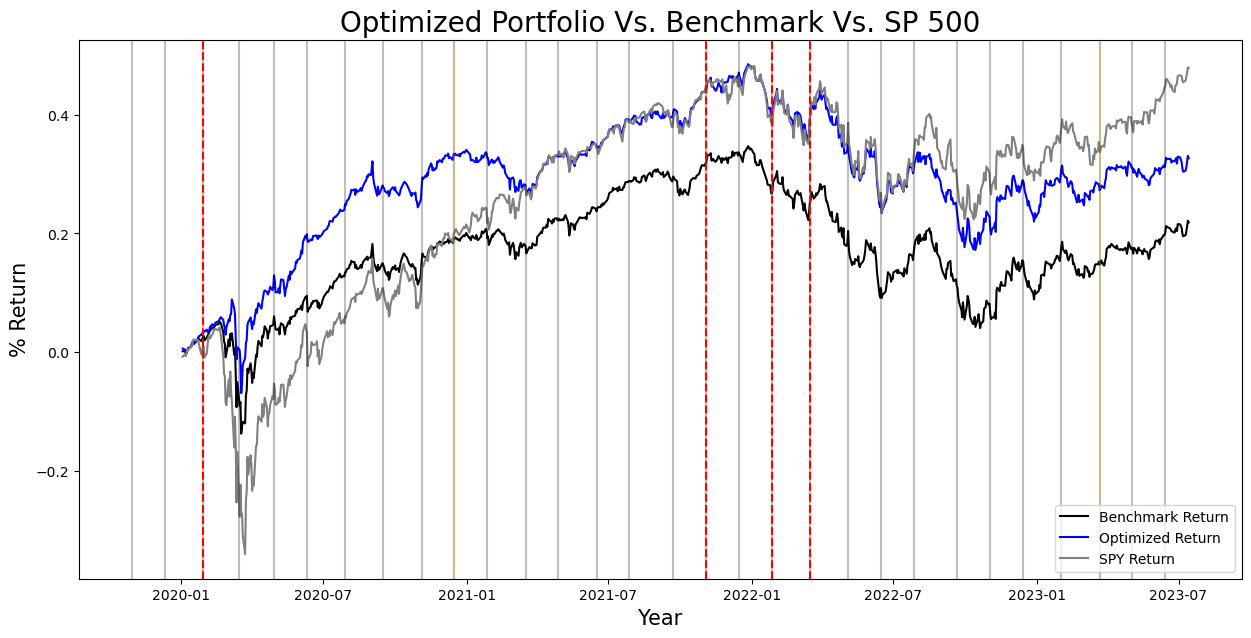

In [61]:



f, ax = plt.subplots(figsize = [15, 7])
years =pd.to_datetime(backtest['Date']).dt.year

ax.plot(pd.to_datetime(backtest['Date']), backtest['Standard_agg'], color='k', label='Benchmark Return')
ax.plot(pd.to_datetime(backtest['Date']), backtest['Optimized_agg'], color='b', label='Optimized Return')
ax.plot(pd.to_datetime(backtest['Date']), backtest['SPY_agg'], color='gray', label='SPY Return')
ax.legend()
plt.title('Optimized Portfolio Vs. Benchmark Vs. SP 500',fontsize=20)
plt.xlabel('Year',fontsize = 15)
plt.ylabel('% Return',fontsize=15)
# Prediction analysis for plotting vertical lines
predictions['shifted_date'] = predictions['Date'].shift(1) # this shifts one month to the left 
predict_error = predictions[(predictions['Prediction']!= predictions['Bull_Bear'])]
predict_bull_error = predictions[(predictions['Prediction']!= predictions['Bull_Bear']) & (predictions['Prediction']==1)]



# date ranges for the above predictions for plotting

date_list2 =list(predict_error['shifted_date'])
date_list3 = list(predict_bull_error['shifted_date'])
date_list4 = list(df['Date'])


for l in range(0,len(date_list4)):
    ax.axvline(*mdates.datestr2num([date_list4[l]]), color='black', alpha=0.25)
    #ax.axvline(datetime.strptime(date_list4[l],'%Y-%m-%d'),color = 'black')


for i in range(0,len(date_list2)):

    ax.axvline(*mdates.datestr2num([date_list2[i]]), color='orange', alpha=0.25)
    
for j in range(0,len(date_list3)):

    ax.axvline(*mdates.datestr2num([date_list3[j]]), color='red',linestyle='--',alpha=1)



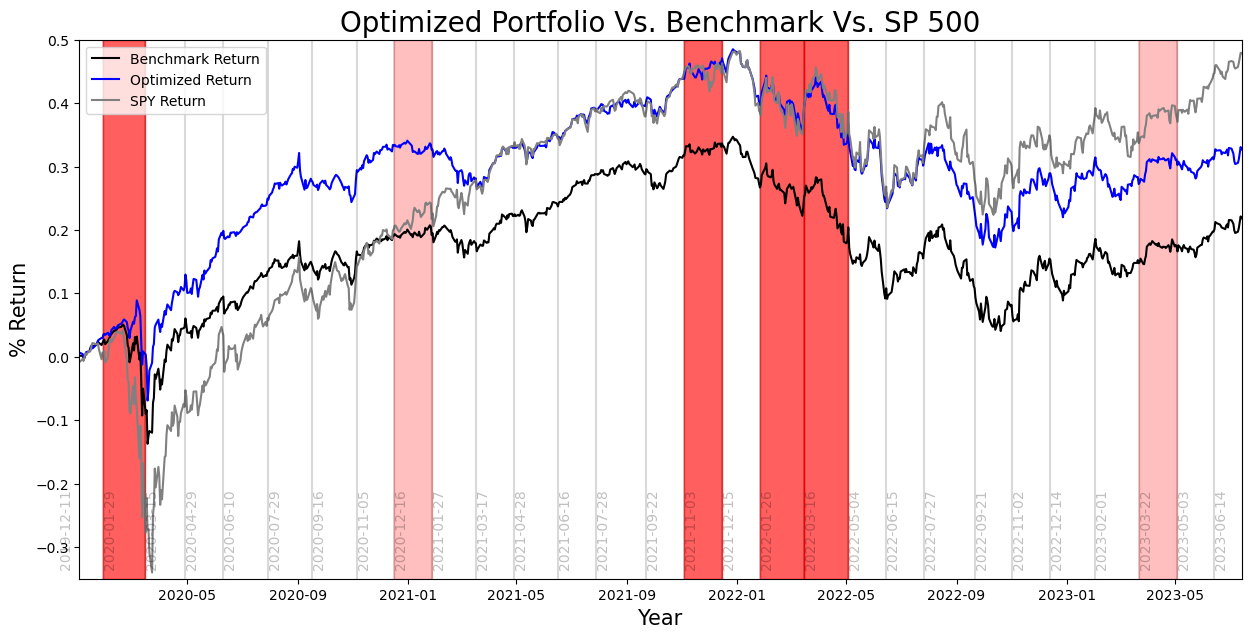

In [62]:
f, ax = plt.subplots(figsize = [15, 7])
years =pd.to_datetime(backtest['Date']).dt.year





ax.plot(pd.to_datetime(backtest['Date']), backtest['Standard_agg'], color='k', label='Benchmark Return')
ax.plot(pd.to_datetime(backtest['Date']), backtest['Optimized_agg'], color='b', label='Optimized Return')
ax.plot(pd.to_datetime(backtest['Date']), backtest['SPY_agg'], color='gray', label='SPY Return')
min_y = -0.35
max_y = 0.5
ax.set_ylim(min_y, max_y)
ax.set_xlim(pd.to_datetime(backtest['Date']).min(),pd.to_datetime(backtest['Date']).max() )
ax.legend(loc = 'upper left')
plt.title('Optimized Portfolio Vs. Benchmark Vs. SP 500',fontsize=20)
plt.xlabel('Year',fontsize = 15)
plt.ylabel('% Return',fontsize=15)
# Prediction analysis for plotting vertical lines
predictions['shifted_date'] = predictions['Date'].shift(1) # this shifts one month to the left 
predict_error = predictions[(predictions['Prediction']!= predictions['Bull_Bear'])]
predict_bull_error = predictions[(predictions['Prediction']!= predictions['Bull_Bear']) & (predictions['Prediction']==1)]



# date ranges for the above predictions for plotting

date_list2 =list(predict_error['Date'])
date_list3 = list(predict_error['shifted_date'])
date_list4 = list(df['Date'])
date_list5 = list(predict_bull_error['Date'])
date_list6 = list(predict_bull_error['shifted_date'])
#ax.axvline(backtest['Date']), color='black', alpha=0.25)
for l in date_list4[1:]:
        ax.axvline(pd.to_datetime(l), color='k', alpha = 0.15)
        plt.text(pd.to_datetime(l),min_y+0.02,str(l),rotation=90,alpha = 0.25)


for (j,k) in zip(date_list2,date_list3):
        #ax.axvline(pd.to_datetime(j), color='r', alpha = 0.45)
   
        ax.axvspan(pd.to_datetime(k), pd.to_datetime(j), ymin=0, ymax=1,color = 'red',alpha = 0.25)

for (a,b) in zip(date_list5,date_list6):
        #ax.axvline(pd.to_datetime(j), color='r', alpha = 0.45)
   
        ax.axvspan(pd.to_datetime(b), pd.to_datetime(a), ymin=0, ymax=1,color = 'red',alpha = 0.5)

#ax.fill_betweenx(pd.to_datetime(predict_error['shifted_date']),pd.to_datetime(predict_error['Date']),label='Missed')


Second attempt, theres a shift going on in dates

In [63]:
predict_error


,Date,Bull_Bear,Prediction,Base_Prediction,shifted_date
3,2020-03-15,0.0,1,1,2020-01-29
10,2021-01-27,1.0,0,0,2020-12-16
17,2021-12-15,0.0,1,1,2021-11-03
19,2022-03-16,0.0,1,1,2022-01-26
20,2022-05-04,0.0,1,1,2022-03-16
28,2023-05-03,1.0,0,0,2023-03-22


In [64]:
# Sharpe Ratio
def Sharpe_func(df,rf_rate,trade_years):

    opt_sigma = []
    st_sigma = []
    spy_sigma = []
    opt_ret = []
    st_ret = []
    spy_ret = []
    opt_sharpe = []
    st_sharpe = []
    spy_sharpe = []
    for i in range(0,len(trade_years)):

        if i < len(trade_years)-1:
            temp_df = df[(df['Date']>= trade_years[i]) & (df['Date'] <= trade_years[i+1])]
            #opt_temp =(temp_df['Optimized_Return'].cumsum()).tail(1).values
            opt_temp =(temp_df['Optimized_Return'].mean())
            #std_temp =(temp_df['Standard_Return'].cumsum()).tail(1).values
            std_temp =(temp_df['Standard_Return'].mean())
            #spy_temp = temp_df['SPY_change'].cumsum().tail(1).values
            spy_temp = temp_df['SPY_change'].mean()
            sigma_opt = (temp_df['Optimized_Return'].std())
            sigma_bench = (temp_df['Standard_Return'].std())
            sigma_spy = (temp_df['SPY_change'].std())
            # returns list
            opt_ret.append(opt_temp)
            st_ret.append(std_temp)
            spy_ret.append(spy_temp)
            # standard dev list
            opt_sigma.append(sigma_opt)
            st_sigma.append(sigma_bench)
            spy_sigma.append(sigma_spy)
            # sharpe
            opt_sharpe.append(((opt_temp-rf_rate/252)/sigma_opt)*252**.5)
            st_sharpe.append(((std_temp-rf_rate/252)/sigma_bench)*252**.5)
            spy_sharpe.append(((spy_temp-rf_rate/252)/sigma_spy)*252**.5)
    return (opt_sharpe,st_sharpe,spy_sharpe)

In [43]:
s_ratios = Sharpe_func(backtest,rf_rate,trade_years)
nlp_sharpe_avg = np.sum(s_ratios[0])/len(s_ratios)
test = np.mean(s_ratios[0])
base_sharpe_avg = np.sum(s_ratios[1])/len(s_ratios)
sp500_sharpe_avg=np.sum(s_ratios[2])/len(s_ratios)
print('NLP Porftolio-Sharpe ',s_ratios[0])
print('\n')
print('Benchmark(60/40) Porftolio-Sharpe ',s_ratios[1])
print('\n')
print('SPY Sharpe ',s_ratios[2])
print('\n')
print('3 Year Avg NLP Portfolio.',nlp_sharpe_avg,'\n','3 Year Avg Benchmark Portfolio.',base_sharpe_avg,'\n','3 Year Avg SPY.',sp500_sharpe_avg)

NLP Porftolio-Sharpe  [2.170952960425432, 1.2464209658766956, -1.3989506438269388]


Benchmark(60/40) Porftolio-Sharpe  [1.0242216232285681, 1.3627037590401678, -1.5343471545403518]


SPY Sharpe  [0.5839131627362985, 1.856013780401703, -0.7920865638923039]


3 Year Avg NLP Portfolio. 0.6728077608250628 
 3 Year Avg Benchmark Portfolio. 0.2841927425761281 
 3 Year Avg SPY. 0.5492801264152325


0.3620085657490852